<a href="https://colab.research.google.com/github/crew-guy/Machine-Learning/blob/main/models/Text_Classify_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text classify/wine-reviews.csv', usecols=['country','description','points','variety','price','winery'])

In [13]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [14]:
df = df.dropna(subset=['description','points'])

In [15]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


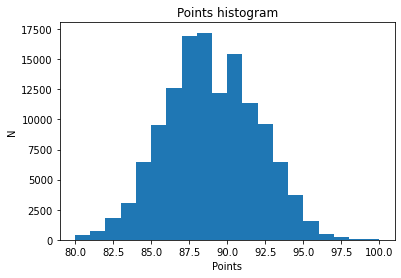

In [16]:
plt.hist(df.points, bins = 20)
plt.title('Points histogram')
plt.xlabel('Points')
plt.ylabel('N')
plt.show()

In [17]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

In [18]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [20]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [21]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [24]:
# a utility function that converts each training, validation, and test set DataFrame into a tf.data.Dataset, then shuffles and batches the data.
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [27]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [31]:
train.head()

,description,label
120519,"A rounded style, with full-bodied red fruits a...",0
78334,"Fruity, with pie-filling flavors of blackberri...",0
29406,"This wine offers soft, malleable red berry, va...",0
101809,This vineyard produces quite good Pinots for J...,0
121583,Luscious honey tangerine and grapefruit flavor...,0


In [32]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"This is a gentle, fruity and open wine that's full of rounded spiced-fruit flavors. It is attractive, with a fine balance of acidity. Ready to drink.",
        b'Pretty good and solid for an uncommon blend, but the Chardonnay and Pinot Grigio thrown together results in nice buttercup aromas along with some apple pie and pear. The palate runs sweet but maintains its freshness, and the flavors of apple, pear, melon and powdered sugar come together. A novelty wine that shows the right signs.',
        b"Here's a ripe, chewy expression of Vino Nobile that opens with aromas of black cherry, dark fruit and even a touch of strawberry. The jammy fruit element is supported by wood tones that add structure and depth without taking away from the overall picture.",
        ...,
        b'Nicely balanced for dinner time, this dry wine is not too fat and not too lean, but just right. It has raspberry aromas, fresh berry flavors and a touch o

In [33]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=False)

In [34]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.31499732, -0.06714822,  0.14026134, ..., -0.15819263,
        -0.19965053,  0.13035221],
       [ 0.4503055 , -0.00601299, -0.04258188, ..., -0.01221379,
        -0.29598922,  0.12437639],
       [ 0.24545066, -0.33639792,  0.01020654, ...,  0.13942365,
        -0.11871976, -0.10783476],
       ...,
       [ 0.13849996, -0.1535761 ,  0.05405834, ...,  0.06060409,
         0.16112266, -0.09720953],
       [ 0.19493172, -0.07249501,  0.01823061, ...,  0.163135  ,
        -0.39462638,  0.11749037],
       [ 0.35686553, -0.2662619 ,  0.01700219, ..., -0.08367151,
         0.2316662 ,  0.15453073]], dtype=float32)>

In [60]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss=tf.keras.losses.BinaryCrossentropy()
)

In [62]:
model.evaluate(train_data)

102/102 [==============================] - 1s 10ms/step - loss: 0.6783 - accuracy: 0.6163


[0.6783055663108826, 0.6162768602371216]

In [63]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 12ms/step - loss: 0.6780 - accuracy: 0.6191


[0.6780004501342773, 0.6191428899765015]

In [64]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 2s 13ms/step - loss: 0.6545 - accuracy: 0.6270 - val_loss: 0.6288 - val_accuracy: 0.6505
Epoch 2/10
102/102 [==============================] - 1s 13ms/step - loss: 0.6140 - accuracy: 0.6669 - val_loss: 0.5952 - val_accuracy: 0.6872
Epoch 3/10
102/102 [==============================] - 1s 12ms/step - loss: 0.5924 - accuracy: 0.6843 - val_loss: 0.5827 - val_accuracy: 0.6980
Epoch 4/10
102/102 [==============================] - 1s 12ms/step - loss: 0.5857 - accuracy: 0.6892 - val_loss: 0.5782 - val_accuracy: 0.7000
Epoch 5/10
102/102 [==============================] - 1s 12ms/step - loss: 0.5814 - accuracy: 0.6921 - val_loss: 0.5762 - val_accuracy: 0.7023
Epoch 6/10
102/102 [==============================] - 1s 12ms/step - loss: 0.5775 - accuracy: 0.6967 - val_loss: 0.5742 - val_accuracy: 0.7019
Epoch 7/10
102/102 [==============================] - 1s 13ms/step - loss: 0.5765 - accuracy: 0.6977 - val_loss: 0.5740 - val_accuracy: 0.7035

{'loss': [0.654528796672821, 0.613990843296051, 0.5924261808395386, 0.5856571197509766, 0.581361711025238, 0.5774875283241272, 0.5764914751052856, 0.5745075941085815, 0.5728843212127686, 0.571784496307373], 'accuracy': [0.6269716024398804, 0.6669135093688965, 0.6843309998512268, 0.6892359852790833, 0.6921308636665344, 0.6966800093650818, 0.6976609826087952, 0.6994594931602478, 0.7005078196525574, 0.7015272974967957], 'val_loss': [0.6288489103317261, 0.595176100730896, 0.5826964378356934, 0.5782351493835449, 0.5762144923210144, 0.5741585493087769, 0.5740170478820801, 0.5718393325805664, 0.5704993009567261, 0.569655179977417], 'val_accuracy': [0.6505347490310669, 0.6871585845947266, 0.6980072259902954, 0.7000076770782471, 0.7023159265518188, 0.7018542885780334, 0.7034700512886047, 0.7040855288505554, 0.7053166031837463, 0.7080095410346985]}


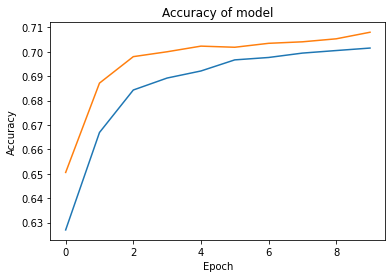

In [65]:
print(history)
print(history.history)
plt.plot(history.history['accuracy'], label='Traning eg')
plt.plot(history.history['val_accuracy'], label='Valid eg')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of model')
plt.show()

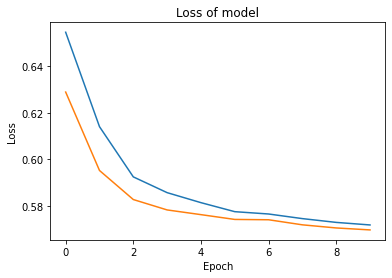

In [66]:
plt.plot(history.history['loss'], label='Traning eg')
plt.plot(history.history['val_loss'], label='Valid eg')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of model')
plt.show()

In [67]:
model.evaluate(test_data)

13/13 [==============================] - 0s 10ms/step - loss: 0.5669 - accuracy: 0.7049


[0.5669208765029907, 0.7048776745796204]

# LSTM

In [68]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000) # max_tokens = max_number of words we gonna remember
encoder.adapt(train_data.map(lambda text, label:text)) # return only the text from our training data, not the labels

In [69]:
vocab = np.array(encoder.get_vocabulary()) # represents the words that are encoded in our encoder. [UNK] refers to unknown tokens
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [73]:
model = tf.keras.Sequential([
    encoder, #vectorizes our text
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True # handles variable sequence lenghts
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [74]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics =['accuracy']
)

In [75]:
model.evaluate(train_data)

102/102 [==============================] - 31s 249ms/step - loss: 0.6935 - accuracy: 0.4654


[0.6934556365013123, 0.4654150903224945]

In [76]:
model.evaluate(valid_data)

13/13 [==============================] - 4s 267ms/step - loss: 0.6935 - accuracy: 0.4571


[0.6935015916824341, 0.45710548758506775]

In [78]:
history = model.fit(train_data, epochs =5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 51s 492ms/step - loss: 0.3601 - accuracy: 0.8348 - val_loss: 0.3618 - val_accuracy: 0.8340
Epoch 2/5
102/102 [==============================] - 49s 477ms/step - loss: 0.3458 - accuracy: 0.8439 - val_loss: 0.3565 - val_accuracy: 0.8393
Epoch 3/5
102/102 [==============================] - 50s 491ms/step - loss: 0.3392 - accuracy: 0.8469 - val_loss: 0.3576 - val_accuracy: 0.8365
Epoch 4/5
102/102 [==============================] - 48s 473ms/step - loss: 0.3353 - accuracy: 0.8475 - val_loss: 0.3556 - val_accuracy: 0.8377
Epoch 5/5
102/102 [==============================] - 49s 479ms/step - loss: 0.3303 - accuracy: 0.8507 - val_loss: 0.3561 - val_accuracy: 0.8362


In [79]:
model.evaluate(test_data)

13/13 [==============================] - 4s 307ms/step - loss: 0.3495 - accuracy: 0.8362


[0.34946542978286743, 0.8362055420875549]